## <center>CITS5508 Lab Sheet 3: <br> Decision Trees (DT) and Support Vector Machines (SVM)

---




**Name: James Mok**<br>
**Student number: 21120365**<br>
**Date created:** March 20th 2019<br>
**Last modified:** April 5th 2019<br>

This lab aims to explore two algorithims, *Support Vector Machines* and *Decision Trees* for two different projects. The projects entail classification and regression algorithms, involving the stages of pre-processing of data, feature scaling, training, scoring and more.

# Project 1
## 1.0 Classifying Cellular Localisation Sites of Proteins on E. Coli Bacteria Data

In this project, it was identified that there was 8 different classes that were used to classify the data. So first, information about the specific classes needed to be identified to understand the data better.

## 1.1 Understanding the E. Coli dataset

From `ecoli.names`relevant details have been shown below:

**Number of Attributes** <br> for E.coli dataset:  8 ( 7 predictive, 1 name )
     
Already, we can see based on the description of `Sequence Name`, this can be **removed** since it is irrelevant to the prediction.

**Class Distribution:**

    cp  (cytoplasm)                                    143
    im  (inner membrane without signal sequence)        77               
    pp  (perisplasm)                                    52
    imU (inner membrane, uncleavable signal sequence)   35
    om  (outer membrane)                                20
    omL (outer membrane lipoprotein)                     5
    imL (inner membrane lipoprotein)                     2
    imS (inner membrane, cleavable signal sequence)      2
  
Here, we can also **remove** `omL`, `imL`and `imS`due to insufficent samples to make a prediction on.

In [1]:
#Importing libraries and data files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#From ecoli.notes to identify class headers
headers = ['Sequence Name', 'mcg', 'gvh','lip','chg','aac', 'alm1','alm2','Class Distribution']

#Importing ecoli data
data = pd.read_csv('ecoli.data.txt', sep ='\s+', names = headers) 

#Quick initial visualisation of the data
print('The dimensions of the data set is: \n'  + str(data.shape))
data.head(5)
          

The dimensions of the data set is: 
(336, 9)


,Sequence Name,mcg,gvh,lip,chg,aac,alm1,alm2,Class Distribution
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


## 1.1.1 Removing irrelevant column and classes

Here, `omL`, `imL`, and `imS` will be removed along with `Sequence Names`

Unwanted classes were removed by using  the bit-wise '*not*' and '*and*' functions to create a list of 'wanted' rows.

The selected rows that were determined to be '_true_' were the index numbers, then used in the `loc` function. This now helps isolate the 'wanted' classes that we wish to use.

The dimensions of the data set is: 
(327, 9)


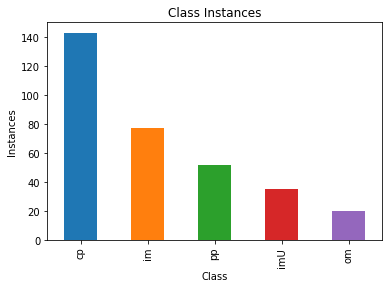

In [2]:
#Removing classes omL, imL and imS
index = data['Class Distribution'] != 'omL'
index = index & (data['Class Distribution'] != 'imL')
index = index & (data['Class Distribution'] != 'imS')

#Storing the new data set without those specific classes
data = data.loc[index]

#Printing shape to check there should be 9 less rows (as identified in ecoli.notes)
print('The dimensions of the data set is: \n'  + str(data.shape))

#Removing Sequence Name
data = data.drop(['Sequence Name'], axis=1)

#Visualising new class distribution
class_instances_new = data['Class Distribution'].value_counts().plot.bar()
class_instances_new.set_title('Class Instances');
class_instances_new.set_xlabel('Class');
class_instances_new.set_ylabel('Instances');

From a quick observation, the dataset is somewhat imbalanced with a difference in one order of magnitude from the class with the largest instances to the smallest.

## 1.2.0 Feature Scaling

First to decide what feature scaling algorithm to use, we will visualise the data to determine this.

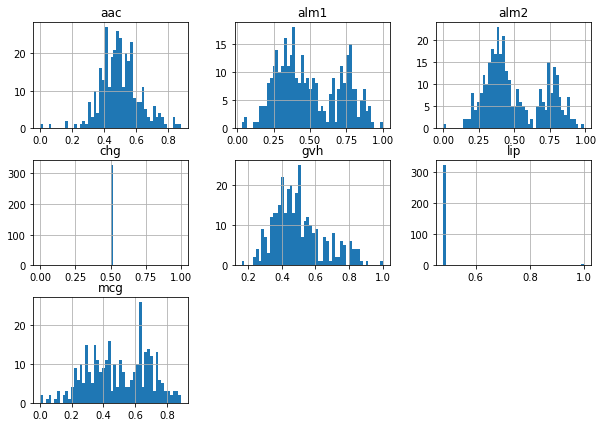

In [3]:
# Plotting historrams to visualise data
data.hist(bins=50, figsize=(10,7))
plt.show()


## 1.2.1 Observations

Below are quick observations of each graph
- aac  - Normally distributed
- alm1  - Normally distributed (Bi-modal)
- alm2  - Normally distributed (Bi-modal)
- chg - Single value
- gvn - Normally distributed
- lip - Single value (Majority)
- mcg  - Normally distributed (Bi-modal)

### Scaling technique
As observed, our data closely resembles a normal distribution, therefore we will use `StandardScaler`

*Note: Through testing I have also confirmed StandardScaler performs better than MinMaxScaler as expected however have not created the code to print these results, to not overload information and maintain readability*
 
### Features with a single value
We can see that *chg* abd *lip* are features which have a single value(where lip is 99% a single value).
Therefore, these features don't provide much information to help distinguish between each class. It may be wise to remove these features to help convergence due to less processing of information, however for the sake of simplicity - the features will be left in. <br>

Keeping the features in or out will yield very close to the same result.


## 1.2.2 Splitting and normalising data

Before we can apply normalisation, the data will be split into training and test sets. After, `StandardScaler` will be applied.

In [4]:
#Splitting and normalising data

# Importing scaler and train,test split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

#Splitting data
data_split = np.split(data, [7,8], axis=1)

#Splitting the data set into training and test set
X_train, X_test, y_train, y_test = train_test_split(data_split[0],data_split[1], test_size=0.2, random_state=20)

#Defining scaler
scaler = StandardScaler()
#scaler = MinMax()

# Scaled training and test sets - where s denotes scaled
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

#Converting to numpy array
#X_train = X_train.values
#X_test = X_test.values


## 1.3 Choosing the SVM and kernel function
In this lab, the task given was to use a *Support Vector Machine* however this comes in many forms
> `SVC`, `LinearSVC` and `SGDClassifier` (using loss='hinge')

### 1.3.1 Selecting the SVM classifier function

First we need to identify which is the most suitable SVM classifer:

> `LinearSVC` -  Uses One vs All (liblinear). This algorithm is faster to converge and uses a linear kernel
 
> `SVC` -  Uses One vs One, (libsvm). This algorithm is less sensitive to problems of imbalanced datasets since it's One vs One but much slower convergence.
 
> `SGDClassifier(loss='hinge')`Linear SVM, Uses SGD and not GD and may have different solution. May generalize better.
 
For more information:
https://scikit-learn.org/stable/modules/svm.html

### Explanation of One vs One or One vs All
In `One vs All`, trains one classifier per class with a total of $N$ classifiers. This labels the selected class as positive and the all of the rest as negative. When this clumps the other classes (*all*) as negatives, this makes it much more sensitive to imbalanced data sets.


In `One vs One`,  trains a classifer for each different pair of labels with $\frac{N(N-1)}{2}\$. This now makes it less sensitive to imbalanced datasets but requires more computational power. 

### Conclusion - choice of SVM function

I have decided to use **`SVC`** due to the small and slightly imbalanced data set. This means the computation times won't be an issue and helps the imbalance of the dataset.



### 1.3.2 Selecting Kernel Function

The kernel is effectively a similarity measure where we can choose between:
> `linear`, `rbf`, `poly`, `sigmoid`or a callable

It is difficult to know which is the  best kernel function to use, where later we can use `GridSearchCV` to find the best method.
Here, I have decided to stick with the default **`rbf`**.

### 1.3.3 Summary

The **`SVC`** function and **`rbf`** kernel will be used.

## 1.4 SVM and Decision Tree Classification Using Normalised and Raw Data

Below is the code for the SVM and DT models:

In [5]:
# Creating Models

#importing libraries
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

#Defining models, where s denotes scaled data and te denotes test set
SVC_clf = SVC(random_state=1).fit(X_train, y_train)
SVC_clf_s = SVC(random_state=1).fit(X_train_s, y_train)
DT_clf = DecisionTreeClassifier(random_state=1).fit(X_train_s, y_train)

#Predictions
SVC_pred = SVC_clf.predict(X_train)
SVC_pred_s = SVC_clf_s.predict(X_train_s)
DT_pred = DT_clf.predict(X_train_s)

SVCte_pred = SVC_clf.predict(X_test)
SVCte_pred_s = SVC_clf_s.predict(X_test_s)
DTte_pred = DT_clf.predict(X_test_s)

#Score will be explained below

## 1.4.1 Measuring the score

When measuring the score here, we have a multilabel problem where we now need to combine the scores of each label to produce an overall score. *Since we already explained accuracy score and F1 score I won't re-explain that for this lab.*

To create a single metric for a multilabel problem using **`F1 Score`**, the parameter `average` is important.

Here are the following methods:
- `binary` - Only applicable to binary labels - N/A
- `macro` - Calculates metrics for each label, and finds their unweighted mean - Doesn't take label imbalance into account.
- `micro` - Counts total true positives, false negatives and false positives - Doesn't take label imbalance into account.
- `weighted` - Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). Better for imbalanced data.
- `samples`- Calculate metrics for each instance, and find their average (only meaningful differs from accuracy_score). - N/A

**Weighted** is the most applicable seeing as our dataset is imbalanced.

## 1.4.2 Results - scores

The scores include the predicted against both training and test set as well as normalised and raw training set for SVM and DT.

In [6]:
#Scoring

# Defining variables for the 'for' loop
name = ['SVM Classifier - Training Set (Normalised)','SVM Classifier - Test Set (Normalised)',
         'SVM Classifier - Training Set (Raw)','SVM Classifier - Test Set (Raw)',
        'Decision Tree Training Set','Decision Tree Test Set']

actual = [y_train, y_test, y_train, y_test, y_train, y_test]
predicted =[SVC_pred_s, SVCte_pred_s, SVC_pred, SVCte_pred, DT_pred, DTte_pred]

#for loop to generate scores using average=weighted method
for i in range(6):
    
    print(str(name[i]) + ':')
    print('Accuracy Score: ' + str("%.2f" % (accuracy_score(actual[i], predicted[i])*100)) + '%')
    print('F1 Score: '+ str("%.2f" % (f1_score(actual[i], predicted[i], average='weighted')*100)) + '%' +'\n')


SVM Classifier - Training Set (Normalised):
Accuracy Score: 90.80%
F1 Score: 90.68%

SVM Classifier - Test Set (Normalised):
Accuracy Score: 83.33%
F1 Score: 83.25%

SVM Classifier - Training Set (Raw):
Accuracy Score: 79.31%
F1 Score: 72.63%

SVM Classifier - Test Set (Raw):
Accuracy Score: 71.21%
F1 Score: 63.88%

Decision Tree Training Set:
Accuracy Score: 100.00%
F1 Score: 100.00%

Decision Tree Test Set:
Accuracy Score: 80.30%
F1 Score: 79.82%



## 1.4.3 Observations - scores

### Training set vs test set
- **SVM** - Not suprisingly the **training set** scored **higher**, scoring on the test set is new data that is has not been trained on, while training set was used for training - test set intuitively does peform slightly worse <br>
- **Decision Tree** - Here the training set performs so well that it scored 100% while the test set was 80%. This shows the decision tree is highly prone to **overfitting** the **training set**.

*Note: After experimenting with `RandomState`, some results yielded the test set performing better than the training set which was unsual but could happen due to chance. Also with the test set being small - it has less diverse data where it may perform better given luck*


### SVM - normalised vs raw training data

The normalised data score performaned much higher than the raw data. This is because SVM's are highly sensitive to scale as it alters how it defines the decision boundaries or 'streets'.

### Comparison - SVM vs Decision Tree

Without tuning, the SVM performaned 10% better so far proving to be more suitable.

## 1.4.4 Results - confusion matricies

This includes both predicted against training and test set as well as normalised and raw training set for SVM.

### Encoding

One of our inputs into our classifier are the classes (categorical data) - which is in the format of a string, where most. <br> Classifiers prefer a numerical input.

Fortunately sk-learns algorithm already does encoding for us so we do not need to this. 

One example of encoding is '**One Hot Encoding**'

**One Hot Encoding** is use where the categorical data have no ordinal relationship between each other. To do this, One Hot Encoding creates new columns for each category and assigns a 1 to the class and 0 to the other classes.

| Red | Green | Blue |
|-----|-------|------|
|  1  |  0  |  0  |
|  0  |  1  |  0  |
|  0  |  0  |  1  |



However, we still need to confirm how our classifer order the labels, below is a simple method to check this.

In [7]:
#Defining Labels by checking classes

labels= SVC_clf.classes_
#labels= SVC_clf.classes_
#labels= SVC_clf_s.classes_
#labels= DT_clf.classes_

print('Order of labels:' + str(labels))

## Note: all the labels are the same order and have omitted printing them all for readability

Order of labels:['cp' 'im' 'imU' 'om' 'pp']


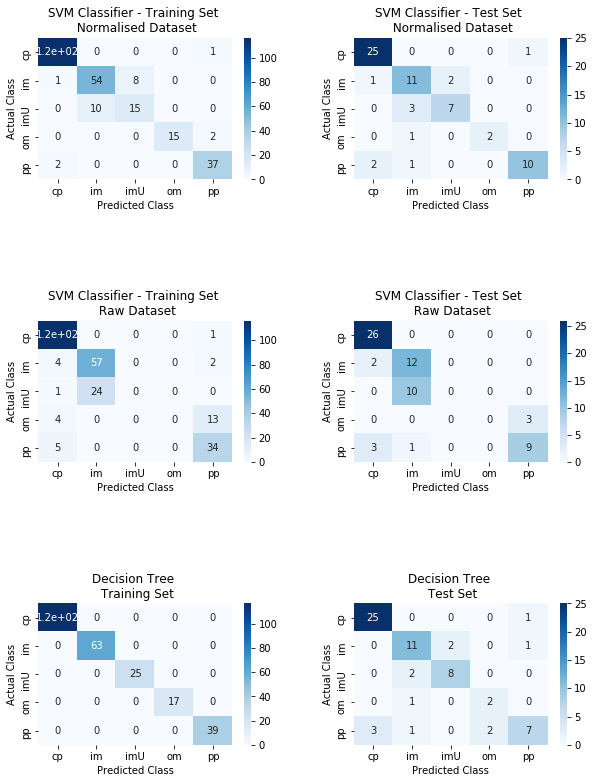

In [8]:
# Creating Confusion Matricies

#Importing lirbaries
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#Confusion matrix
conf_mx_SVC_s = confusion_matrix(y_train, SVC_pred_s)
conf_mxte_SVC_s = confusion_matrix(y_test, SVCte_pred_s)

conf_mx_SVC = confusion_matrix(y_train, SVC_pred)
conf_mxte_SVC = confusion_matrix(y_test, SVCte_pred)

conf_mx_DT = confusion_matrix(y_train, DT_pred)
conf_mxte_DT = confusion_matrix(y_test, DTte_pred)

#Defining labels to go into confusion matrix
cm = [conf_mx_SVC_s,conf_mxte_SVC_s,conf_mx_SVC,conf_mxte_SVC,conf_mx_DT,conf_mxte_DT]
title = ['SVM Classifier - Training Set \n Normalised Dataset','SVM Classifier - Test Set \n Normalised Dataset',
         'SVM Classifier - Training Set \n Raw Dataset','SVM Classifier - Test Set \n Raw Dataset',
        'Decision Tree \n Training Set','Decision Tree \n Test Set']

#Creating figure
fig = plt.figure(figsize=(10,13))
fig.subplots_adjust(hspace = 1, wspace=0.3)

#For loop to cycle through and create the confusion matrices
for i in range(6):

    #Creating confusion matrix 
    ax = fig.add_subplot(3, 2, i+1) 
    sns.heatmap(cm[i], annot = True, xticklabels= labels, yticklabels=labels, cmap='Blues')
    
    #Plot labels
    plt.title(str(title[i]))
    plt.xlabel('Predicted Class');
    plt.ylabel('Actual Class');
    

## 1.4.5 Observations - confusion matricies

From the confusion matrices you can see the better classifiers follow a **strong diagonal pattern**. This is because of the alignment of the labels. <br> Interestingly the **raw data** had **0 correct predictions** in the class **`imU`** and **`om`** showing the how SVM's are susceptible to scaling of data.

## 1.5 Hyperparameter tuning

Here I will only test hyperparamters to see which algorithm performs better, SVM  vs DT, <br>
Therefore, only optimising the normalised SVM model.

### SVM (normalised) - hyperparameter tuning

In [9]:
#Hyperparameter Tuning
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

parameters = {
    'tol':[1,0.5,0.1],
    'C': [2,5,10],
    'kernel': ['rbf','linear','poly','sigmoid'],
    'max_iter': [1,2,5,10,15],
}

#Create Scorer
f1_score_method = make_scorer(f1_score, average = 'macro')

#Cross Validation of 5 segments using F1 score
clf = GridSearchCV(SVC_clf_s, parameters, cv=5,scoring=f1_score_method)
clf.fit(X_train, y_train);

#Print F1 score and best parameters
print('Optimal score and parameters from tuning:')
print(clf.best_score_)
print(clf.best_params_)

Optimal score and parameters from tuning:
0.8600948074210307
{'C': 5, 'kernel': 'linear', 'max_iter': 10, 'tol': 0.5}


### Hyperparameters for SVM

It was particularly important to check the most suitable kernel as well as the **`C`** parameter.

- The **`C`** parameter determins how wide the 'streets' of the SVM are, crucial to determining segregate the classes
- Here we find that actualy the `linear` kernel is most effective and not `rbf`.
- As explained previously, `tol` and `max_iter` are important for convergence towards the optimal score

### Decision Tree - hyperparameter tuning

In [10]:
#Hyperparameter Tuning
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth':[None,1,2,5],
    'min_samples_split':[10,20,30],
    'min_samples_leaf': [5,10,20]
}

#Create Scorer
f1_score_method = make_scorer(f1_score, average = 'macro')


#Cross Validation of 5 segments using F1 score
clf = GridSearchCV(DT_clf, parameters, cv=5,scoring=f1_score_method)
clf.fit(X_train, y_train);

#Print F1 score and best parameters
print('Optimal score and parameters from tuning:')
print(clf.best_score_)
print(clf.best_params_)

Optimal score and parameters from tuning:
0.760989893297439
{'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 30}


### Hyperparameters for decision trees

- `max_depth` - Depth of each tree in the forest. The deeper the tree captures more information of the dataset. 
- `min_samples_split` - Minimum number of samples required to split an internal node.
- `min_samples_leaf`- Minimum number of samples required to be at a leaf node, the base of the tree.

These are all important to tune where the above code highlights the best parameters.

## 1.6 Conclusion - Project 1

SVM (normalised) performed ~10% better than the Decision Tree without hyperparameter tuning.

- This reached ~90% F1_score which is very high consider it wasn't tuned.
- SVM - highlighted that it is sensitive to scaling
- Decision Trees - Prone to overfitting on training set


# Project 2
## 2.0 Using Regression Models to Predict Maximum Temperature

The data explored in this project is from the Bureau of Meteorology (BOM) which has publishes data on global solar exposure as well as Maximum Temperature.

This project will attempt to predict maximum temperature given a month, date and solar exposure value.


## 2.1 Understanding the data

From the documentation provided, from *SolarExposure_2018_Note* and *Temperature_2018_Note* there is information we can already establish.

FIrstly, our lab task is to predict max temperature given month, date and solar exposure value - rendering the other features irrelevant.

The following features will be removed:

- Product Code
- Bureau of Meteorology station number
- Days of accumulation of maximum temperature
- Year
- Quality


### 2.1.1 Merging and trimming data
Below the the data will be imported where the irrelevant data will be trimmed.

After, this data will be merged into one variable, more suitable for the model.


In [11]:
#Project 2 regression problem

#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Importing data
data1= pd.read_csv('SolarExposure_2018_Data.csv')
data2= pd.read_csv('Temperature_2018_Data.csv')

#Drop irrelevant columns
data_sun = data1.drop(['Product code','Bureau of Meteorology station number','Year'],axis=1)
data_temp = data2.drop(['Product code','Bureau of Meteorology station number','Year',
                        'Days of accumulation of maximum temperature','Month','Day', 'Quality'], axis=1)

#Combine both documents to include max temp, solar exposure and month/date
data = pd.concat([data_sun, data_temp], axis=1, sort=False)

#Understanding data through quick visualisation
print('Dimensions of the data set [rows,columns] = ' + str(data.shape))
data.head(10)


Dimensions of the data set [rows,columns] = (365, 4)


,Month,Day,Daily global solar exposure (MJ/m*m),Maximum temperature (Degree C)
0,1,1,31.8,34.0
1,1,2,31.8,37.7
2,1,3,31.7,29.8
3,1,4,31.6,30.9
4,1,5,24.8,26.1
5,1,6,31.5,27.3
6,1,7,31.5,30.2
7,1,8,31.5,33.4
8,1,9,31.3,34.8
9,1,10,31.4,28.3


##  2.1.3 Visualising the relationships of the data
    
Let's visualise some of the data we have here in
    
Below we try to break down into Max temperature vs features(month, day, solar exposure)


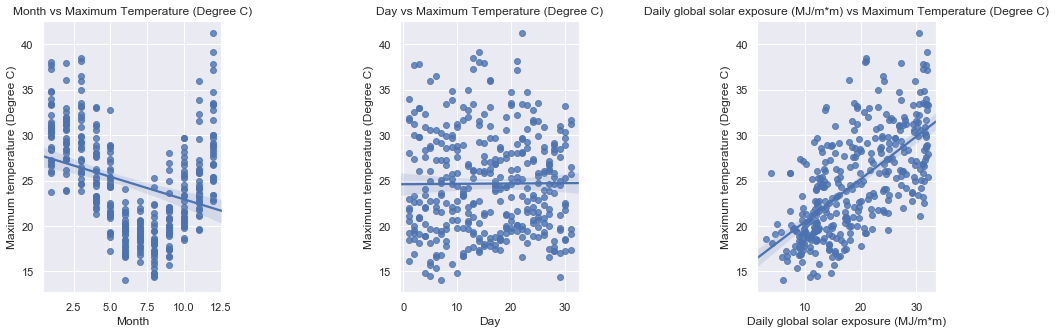

In [12]:
# Plotting the features vs Max temperature

#Importing visualisation tools
import seaborn as sns; sns.set(color_codes=True)
tips = sns.load_dataset("tips")

#Plotting Solar exposure vs Maximum temperature
feat = ['Month','Day','Daily global solar exposure (MJ/m*m)']

#Creating figures for Max temperature vs features (month, day, solar exposure)
fig = plt.figure(figsize=(16,5))
fig.subplots_adjust(hspace = 0.5, wspace=1)

#for loop to create plots
for i in range (3):
    
    #using replot to create scatter plot with line of best fit
    f = fig.add_subplot(1,3,i+1)
    ax = sns.regplot(x = data[feat[i]], y = data['Maximum temperature (Degree C)'])
    plt.title(feat[i] + ' vs Maximum Temperature (Degree C)')
    


This provides an understanding of each feature and its relationship to Max Temperature. We can see a linear relationship with sun exposure and Max temperature. However for months and days the correlation seems to be non-linear.

**However, conclusions can not be made with features in isolation, we need to consider this all together.** <br> *Note: a 4-D plot would be hard to interpret so I have avoided this.*

## 2.1.4 Visualising the data throughout the year

The relationship of the data is hard to visual for this case, so we will visualise the data results - Maximum temperature throughout the year.

Below is a plot to visualise this:



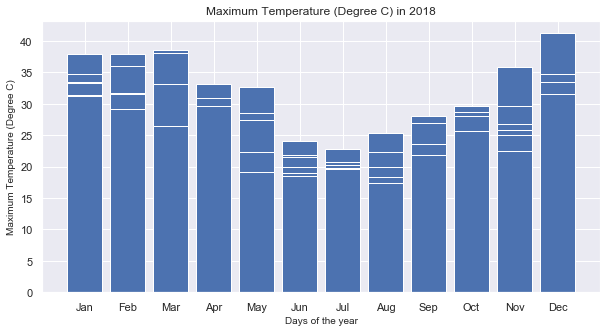

In [13]:
# Visualising Max temperature throughout the year
from numpy import median

#Create new column of days in the year
#x = list(range(1,366))

#Creating column for months (Not used)
months ={1: 'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
             7: 'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'
        }
         
x = list(map(months.get, data['Month']))

#Creating plot
fig,ax = plt.subplots(figsize=(10,5))
ax = plt.bar(x, data['Maximum temperature (Degree C)'])
plt.xlabel('Days of the year', fontsize=10)
plt.ylabel('Maximum Temperature (Degree C)', fontsize=10)
plt.title('Maximum Temperature (Degree C) in 2018')
plt.show()

This plot gives us a rough idea what the expected Maximum Temperature is throughout the year.

*Note: I plotted this according to months to allow a quick visual on the data*

## 2.2 Feature Scaling

FIrst lets visualise our data to determine the method of feature scaling.


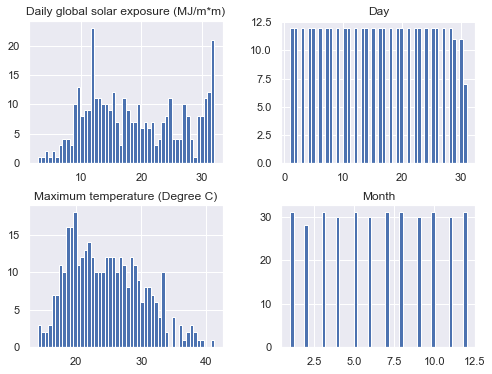

In [14]:
#Visualising data
data.hist(bins = 50 ,figsize = (8,6))
plt.show()

From this data it is hard to tell which scaler to use, as it is not *obviously* normally distributed. Below I have tested a few different normalisation methods.

### 2.2.1 Splitting and normalising data

In [15]:
#Defining scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

#Splitting data
data_split = np.split(data,[3,4], axis=1)

#Splitting the data set into training and test set
X_train, X_test, y_train, y_test = train_test_split(data_split[0],data_split[1], test_size=0.2, random_state=20)

# Scaled training and test sets
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

#Converting to numpy array
X_train = X_train.values
X_test = X_test.values

*Note:I have ended up using `StandardScaler`.*

*Through testing of `MinMaxScaler`, `StandardScaler`, and `RobustScaler`. `StandardScaler` and `RobustScaler` performed similar where `StandardScaler` was slightly better, `MinMaxScaler` performed worse.

*I have decided not to print the results to maintain clarity of information and readability*

## 2.3 Regression models -  SVC Regressor vs DT Regressor

Both regression models are below:

In [16]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

#Defining models
SVR_reg = SVR().fit(X_train, y_train)
SVR_reg_s = SVR().fit(X_train_s, y_train)
DT_reg = DecisionTreeRegressor(random_state=1).fit(X_train_s, y_train)

#Predictions, s = scaled and te = test
SVR_pred = SVR_reg.predict(X_train)
SVR_pred_s = SVR_reg_s.predict(X_train_s)
DT_pred = DT_reg.predict(X_train_s)

SVRte_pred = SVR_reg.predict(X_test)
SVRte_pred_s = SVR_reg_s.predict(X_test_s)
DTte_pred = DT_reg.predict(X_test_s)

#MSE will be shown below

## 2.3.1 Results - mean squared error

In [17]:
#MSE
from sklearn.metrics import mean_squared_error

#defining titles
name = ['SVM Regressor - Training Set (Normalised)','SVM Regressor - Test Set (Normalised)',
         'SVM Regressor - Training Set (Raw)','SVM Regressor - Test Set (Raw)',
        'Decision Tree Regressor Training Set','Decision Tree Regressor Test Set']

#defining actual and predicted values
actual = [y_train, y_test, y_train, y_test, y_train, y_test]
predicted = [SVR_pred_s, SVRte_pred_s, SVR_pred, SVRte_pred, DT_pred, DTte_pred]

#for loop to generator MSE
for i in range(6):
    
    print(str(name[i]) + ':')
    print('Mean Squared Error: '+ str("%.2f" % (mean_squared_error(actual[i],predicted[i])))  +'\n')

SVM Regressor - Training Set (Normalised):
Mean Squared Error: 10.74

SVM Regressor - Test Set (Normalised):
Mean Squared Error: 10.79

SVM Regressor - Training Set (Raw):
Mean Squared Error: 17.69

SVM Regressor - Test Set (Raw):
Mean Squared Error: 22.01

Decision Tree Regressor Training Set:
Mean Squared Error: 0.00

Decision Tree Regressor Test Set:
Mean Squared Error: 17.01



## 2.3.2 Observations - mean squared error

### Training vs test set
- SVM - Here the training and test sets were quite similar which is reasonable where the raw data had a bigger different most likely due to SVM's sensitivity to scaling. However, **similar for the most part**.
- Decision Tree -  We see again for Decision Tree's the training set is overfitted

### SVM Raw vs Normalised

As explained earlier due to the sensitivity of SVM's to scaling, the normalised data sets performed much better as expected

### SVM vs Decision tree

Interestingly without hyperparameter tuning the SVM performed quite a bit better than Decision Trees.

## 2.3.3 Results - visualisations

### Visualising the model performanee for against a specific feature

One interesting thing to plot is how the predictions were compared to the actual data.

Below shows just one example for the feature Solar Exposure using the SVM normalised test set, highlighting the differences of model vs actual.

In [18]:
#Creating another test set to be used for comparison against SVM - normalised test set (SVRte_pred_s)
y_test1=y_test
y_test1=y_test1.reset_index().values
y_test1[:,1];

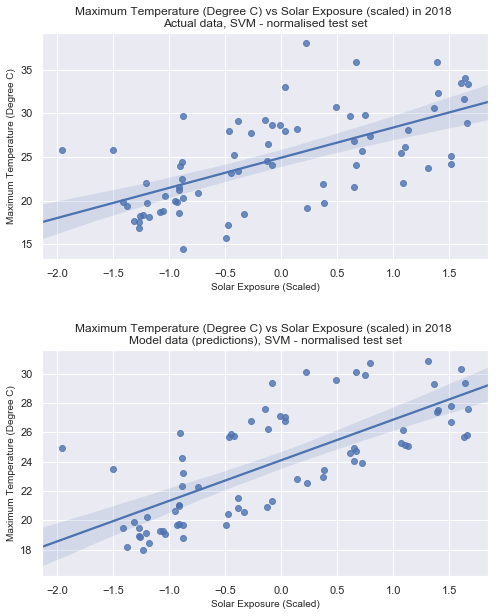

In [19]:
# Comparing predicted output vs actual output

#Plotting Solar exposure vs Maximum temperature
feat = ['Month','Day','Daily global solar exposure (MJ/m*m)']
yy= [y_test1[:,1],SVRte_pred_s]
type = ['Actual data','Model data (predictions)']

#Creating plots
fig = plt.figure(figsize=(8,10))
fig.subplots_adjust(hspace = 0.4, wspace=0.3)

#For loop for plots actual vs model for SVM normalised test set and for solar exposure
for i in range (2):
    
    f = fig.add_subplot(2,1,i+1)
    ax1 = sns.regplot(x = X_test_s[:,2], y = yy[i])
    plt.xlabel('Solar Exposure (Scaled)', fontsize=10)
    plt.ylabel('Maximum Temperature (Degree C)', fontsize=10)
    plt.title('Maximum Temperature (Degree C) vs Solar Exposure (scaled) in 2018 \n'+ str(type[i]) +
              ', SVM - normalised test set')

The interesting thing here to note is that the **spread from the model** is quite unique. Here we see that there seems to be some **variance** above and beow the line of best fit whilst in the **actual data**, it looks much more **realistic**.

Again, this visualisation needs to be taken with a grain of salt as we can't view the data from a 1-dimensional input and this problem has 2 other features.

### Visualisation the instances of actual vs model data

Another way to visualise the outcome is based off instances - actual vs predicted.

However this is not so useful, but I have included this anyway.

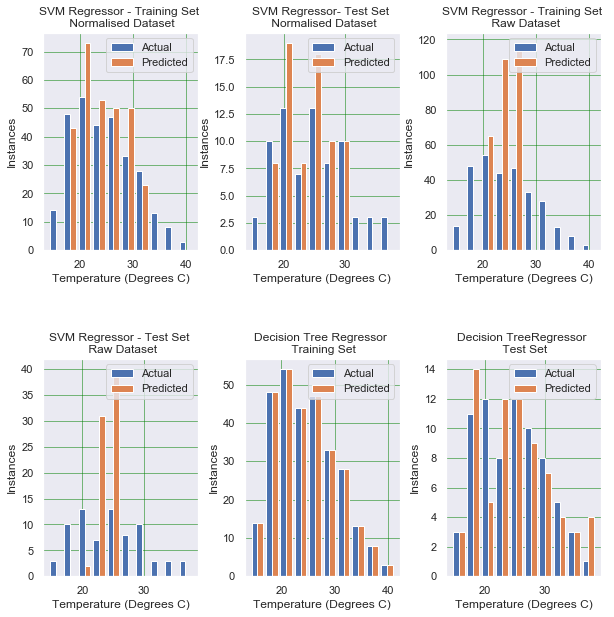

In [20]:
#Defining titles
title = ['SVM Regressor - Training Set \n Normalised Dataset','SVM Regressor- Test Set \n Normalised Dataset',
         'SVM Regressor - Training Set \n Raw Dataset','SVM Regressor - Test Set \n Raw Dataset',
        'Decision Tree Regressor \n Training Set','Decision TreeRegressor \n Test Set']

#defining actual and predicted
actual = [y_train, y_test, y_train, y_test, y_train, y_test]
predicted = [SVR_pred_s, SVRte_pred_s, SVR_pred, SVRte_pred, DT_pred, DTte_pred]

#Creating figure
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace = 0.5, wspace=0.3)

#For loop to cycle through and create the confusion matrices
for i in range(6):
    
    #Creating plots
    ax = fig.add_subplot(2, 3, i+1) 
    
    plt.hist([actual[i],predicted[i]],label=['Actual','Predicted'])    
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    #Plot labels
    plt.title(str(title[i]))   
    plt.legend()
    plt.xlabel('Temperature (Degrees C)')
    plt.ylabel('Instances')
    

We do however interesting observe that for the Raw dataset that the predicted values are very clumped together to a small variance, and not representing the actual spread of data very well.

### Actual vs predicted maximum temperatures throughout the year

Lastly, this plot is the most useful to visualise how well the model performed.

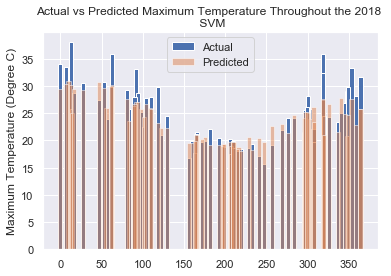

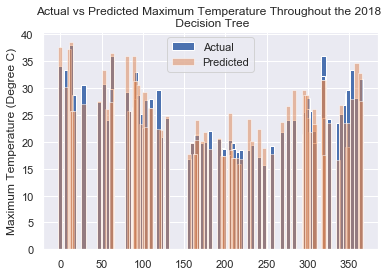

In [21]:

titles = ['Actual vs Predicted Maximum Temperature Throughout the 2018 \n SVM',
         'Actual vs Predicted Maximum Temperature Throughout the 2018 \n Decision Tree']

y_pred=[SVRte_pred_s, DTte_pred]
x_ax= y_test.index.values
y_ax = y_test['Maximum temperature (Degree C)'].values

for i in range(2):    
    
    ax = fig.add_subplot(2,1,i+1)
    p1 = plt.bar(x_ax,y_ax,width=5)
    p2 = plt.bar(x_ax, y_pred[i],width=5,alpha=0.5)

    plt.ylabel('Maximum Temperature (Degree C)')
    plt.title(titles[i])
    plt.legend((p1[0], p2[0]), ('Actual', 'Predicted'))
    plt.show()

From this plot, we can clearly see the differences of the model vs actual data throughout the year 2018. Since this only took into account the test set, there was lots of gaps. However, this is more reasonable than plotting the entire year which would make the plot hard to read.

## 2.4 Hyperparameter tuning

Here I will only test hyperparamters to see which algorithm performs better, SVM  vs DT.

Therefore I will only optimise the normalised SVM model

### SVM - normalised hyperparameter tuning

In [22]:
#Hyperparameter Tuning
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

parameters = {
    'tol':[0.001,0.1,1],
    'C': [0.001,0.01,0.1],
    'kernel': ['rbf','linear','poly','sigmoid'],
    'max_iter': [150,200,250],
    'epsilon': [1,2,3,4]
}

#Cross Validation of 5 segments using negative MSE (due to the algorithm maximising the score providing high MSE)
reg = GridSearchCV(SVR_reg_s, parameters, cv=5, scoring = 'neg_mean_squared_error')
reg.fit(X_train, y_train);

#Print Optimal MSE and best parameters (multiple by -1 to make positive for MSE)
print('Optimal MSE and best parameters from tuning:')
print(reg.best_score_*-1)
print(reg.best_params_)

Optimal MSE and best parameters from tuning:
13.842396702274213
{'C': 0.01, 'epsilon': 2, 'kernel': 'linear', 'max_iter': 150, 'tol': 0.1}


Here we have a new hyperparamter which is `Epsilon`:
- This is another important parameter to consider as it denotes the amount of error allowed, affecting the number of support vectors. The larger the error, the fewer support vectors and vice-versa.

### Decision Tree hyperparameter tuning

In [23]:
#Hyperparameter Tuning
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth':[None,1,2,5],
    'min_samples_split':[2,3,5],
    'min_samples_leaf': [10,20,30]
}

#Cross Validation of 5 segments using negative MSE (due to the algorithm maximising the score providing high MSE)
reg = GridSearchCV(DT_reg, parameters, cv=5, scoring = 'neg_mean_squared_error')
reg.fit(X_train, y_train);

#Print Optimal MSE and best parameters (multiple by -1 to make positive for MSE)
print('Optimal parameters from tuning:')
print((reg.best_score_)*-1)
print(reg.best_params_)

Optimal parameters from tuning:
12.287265094455789
{'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 2}


The findings for this is similar to Project 1

## 2.5 Conclusion - Project 2

SVM performed better compared to Decision Trees, which a better MSE of ~7.

- SVM again showed sensitive to scaling proved by the raw data.
- Training set performed better and especially for Decision Tree, overfits the data.

The data plotted of Maximum temperature throughout the year showing actual and predicted is a nice summary of how the model performed.

## 3.0 Summary of lab 3

This lab was another great experience but also provided many challenges!

My key takeaways were:

- Intuition and relationships of SVM's and Decision Tree's
- Intuition behind regression vs classification problems
- Manipulating data through dropping collumns, indexing and more.
- Visualation of data - Understanding the most effecting plot but also coding the plots

Thank you for reading!